<a href="https://colab.research.google.com/github/AmritS7/Segmentation-Based-Geolocation/blob/main/GeolocationPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation Preprocessing
Amritpal Singh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd

#### Using Latitudes and Longitudes of Streetview Dataset to Determine Country

In [ ]:
import reverse_geocoder as rg #library that allows us to get country locations for a pair of coordinates, pip install if required

streetview_df = pd.read_csv("./Images/ayuseless/Streetview_Image_Dataset/coordinates.csv")

In [ ]:
streetview_df.head()

,latitude,longitude
0,20.824885,-98.499517
1,-3.451752,-54.563937
2,-23.496464,-47.460542
3,-16.548678,-72.852778
4,-35.010870,140.064397


In [ ]:
tuples = list(zip(streetview_df['latitude'], streetview_df['longitude'])) #convert into tuple format for reverseg_geocoder

In [ ]:
results = rg.search(tuples) #get resulting countries

Loading formatted geocoded file...


In [ ]:
country_df = pd.read_csv("./Images/CountryCodes.csv") #get country names for country codes

country_df.head()

,ISO,Name
0,AD,Andorra
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Antigua and Barbuda
4,AI,Anguilla


In [ ]:
#merge based on country code
cc_list = [e['cc'] for e in results ]
country_cc_df = pd.DataFrame({'cc': cc_list})
country_cc_df = country_cc_df.merge(country_df, how="left", left_on='cc', right_on='ISO')

In [ ]:
country_cc_df

,cc,ISO,Name
0,MX,MX,Mexico
1,BR,BR,Brazil
2,BR,BR,Brazil
3,PE,PE,Peru
4,AU,AU,Australia
...,...,...,...
25224,PH,PH,Philippines
25225,PH,PH,Philippines
25226,PH,PH,Philippines
25227,PH,PH,Philippines


In [ ]:
streetview_df['file_name'] = [f"{i}.png" for i in streetview_df.index] #set filename to columnname (files are originally named 0.png - 25228.png)

In [ ]:
streetview_df['country'] = country_cc_df['Name']

In [ ]:
streetview_df.head()

,latitude,longitude,file_name,country
0,20.824885,-98.499517,0.png,Mexico
1,-3.451752,-54.563937,1.png,Brazil
2,-23.496464,-47.460542,2.png,Brazil
3,-16.548678,-72.852778,3.png,Peru
4,-35.010870,140.064397,4.png,Australia


#### Combining Datasets into a Single Combined Dataset

In [ ]:
#for streetview dataset
import os

source_directory = "./Images/ayuseless/Streetview_Image_Dataset"
destination_directory = "./Images/combined_ds/"

for index, row in streetview_df.iterrows(): #loop through dataframe and save files to combined_dataset with the correct folder
  filename = row['file_name']
  country = row['country']

  if pd.isna(country): #skip na (~10 images where rg couldnt decide on a country)
    continue


  destination_path = os.path.join(destination_directory, country, filename)

  if not os.path.exists(os.path.dirname(destination_path)):
    os.makedirs(os.path.dirname(destination_path))


  source_path = os.path.join(source_directory, filename)
  os.rename(source_path, destination_path) #move file to correct path

In [ ]:
#for geoguesser dataset
import os
directory_path = "./Images/compressed_dataset/"

for root, dirs, files in os.walk(directory_path):


    current_dir = os.path.basename(root)

    for file in files: #loop through each folder in the dataset

        folder_path = f"./Images/combined_ds/{current_dir}"

        if not os.path.exists(os.path.join(folder_path, file)):

            im = Image.open(os.path.join(root,file))
            width, height = im.size

            left = (width - 662)/2
            top = (height - 662)/2
            right = (width + 662)/2
            bottom = (height + 662)/2

            im = im.crop((left, top, right, bottom)) #crop image to center (convert to square)
            im = im.resize((640,640)) #resize to match streetview size

            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            im.save(os.path.join(folder_path, file)) #save the image

In [ ]:
#remove folders that contain less than 75 images
import os
import shutil
directory_path = "./Images/combined_ds/"

for root, dirs, files in os.walk(directory_path):

  current_dir = os.path.basename(root)

  image_count = len([f for f in files if f.lower().endswith((".jpg", ".png", ".jpeg"))])

  if image_count < 75:
    if root!="./Images/combined_ds/":
      print(f"Deleting directory '{current_dir}' with {image_count} images (below threshold)")
      shutil.rmtree(root)


Deleting directory 'Aland' with 9 images (below threshold)
Deleting directory 'Albania' with 54 images (below threshold)
Deleting directory 'Algeria' with 3 images (below threshold)
Deleting directory 'American Samoa' with 16 images (below threshold)
Deleting directory 'Andorra' with 22 images (below threshold)
Deleting directory 'Antarctica' with 1 images (below threshold)
Deleting directory 'Armenia' with 13 images (below threshold)
Deleting directory 'Belarus' with 13 images (below threshold)
Deleting directory 'Belize' with 3 images (below threshold)
Deleting directory 'Bermuda' with 3 images (below threshold)
Deleting directory 'Bhutan' with 31 images (below threshold)
Deleting directory 'Bosnia and Herzegovina' with 1 images (below threshold)
Deleting directory 'Burkina Faso' with 10 images (below threshold)
Deleting directory 'China' with 46 images (below threshold)
Deleting directory 'Costa Rica' with 37 images (below threshold)
Deleting directory 'Cuba' with 3 images (below th

### Creating Appliable Weighted Masks Using SAM Segmentation and Custom Classes

In [ ]:
import torchvision
import torch
from torchvision import transforms

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

#!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

PyTorch version: 2.2.2+cu121
Torchvision version: 0.17.2+cu121
CUDA is available: True


In [ ]:
resnet = torchvision.models.resnet50(pretrained="true") #import resnet

c:\Users\Amritpal\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Amritpal\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transform = transforms.Compose([ #transform to be applied to images that will be used for mask generation
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
 )])

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = 'cuda'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam) #import sam model

In [ ]:
def crop_segmented_image(mask, padding_color=(0, 0, 0)): #crop segmented image into a square with black padding
    """Crops the segmented image with a square bounding box around the largest contour."""

    # Convert mask to grayscale and threshold
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours and largest contour
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Determine side length of the square bounding box
    side_length = max(w, h)

    # Calculate the padding needed to make the bounding box square
    pad_x = (side_length - w) // 2
    pad_y = (side_length - h) // 2

    # Create a new image with the square bounding box and padding
    padded_mask = np.full((side_length, side_length, 3), padding_color, dtype=np.uint8)

    # Paste the cropped mask into the padded image
    cropped_mask = mask[y:y+h, x:x+w]
    padded_mask[pad_y:pad_y+h, pad_x:pad_x+w] = cropped_mask

    plt.figure(figsize=(5, 5))
    plt.imshow(padded_mask)
    plt.show()
    return padded_mask


In [ ]:
with open('./selected_classes.txt') as f: #open manually selected classes (which could signify where we are in a country)
      selected_classes = [line.strip() for line in f.readlines()]

In [ ]:
selected_classes

['airliner',
 'airship',
 'altar',
 'ambulance',
 'bakery',
 'bannister',
 'barbershop',
 'barn',
 'birdhouse',
 'boathouse',
 'bookshop',
 'breakwater',
 'bullet train',
 'butcher shop',
 'cab',
 'canoe',
 'car mirror',
 'car wheel',
 'carousel',
 'castle',
 'chainlink fence',
 'church',
 'cinema',
 'cliff dwelling',
 'container ship',
 'convertible',
 'crane',
 'dam',
 'dock',
 'dome',
 'electric locomotive',
 'entertainment center',
 'fireboat',
 'fire engine',
 'flagpole',
 'fountain',
 'freight car',
 'garbage truck',
 'gas pump',
 'gondola',
 'greenhouse',
 'grocery store',
 'harvester',
 'horse cart',
 'jeep',
 'lawn mower',
 'library',
 'lifeboat',
 'limousine',
 'lumbermill',
 'mailbox',
 'manhole cover',
 'megalith',
 'minibus',
 'minivan',
 'mobile home',
 'monastery',
 'moped',
 'mosque',
 'motor scooter',
 'mountain bike',
 'moving van',
 'obelisk',
 'oxcart',
 'palace',
 'park bench',
 'parking meter',
 'passenger car',
 'patio',
 'pay-phone',
 'pedestal',
 'picket fence'

In [ ]:
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:

def getResnetMasks(image, masks):

  adjusted_image = np.zeros((640,640)) #create new blank canvas
  for mask in masks: #go through each generated mask
    base = np.zeros_like(image)
    base[mask['segmentation']]=image[mask['segmentation']] #set pixels in base visible where true exists in mask

    base = crop_segmented_image(base) #crop to square around true
    img_t = transform(Image.fromarray(base))
    batch_t = torch.unsqueeze(img_t, 0)
    out = resnet(batch_t) #get resnet classes for maske

    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    _, indices = torch.sort(out, descending=True)

    score = 0


    [(print(classes[idx], percentage[idx].item())) for idx in indices[0][:10]]

    for idx in indices[0][:10]: #loop through 10 greates probabilities
      if percentage[idx].item() > 10: #if confidence is greater than 10, apply the confidence value to the location in the adjusted image
         if classes[idx] in selected_classes:
          adjusted_image[mask['segmentation']] = max(adjusted_image[mask['segmentation']][0], int(round(percentage[idx].item())))
          break
      else:
        break



  return adjusted_image.astype(np.uint8)

#### Testing

In [ ]:
test_image = cv2.cvtColor(cv2.imread("./Images/combined_ds/United Kingdom/22100.png"), cv2.COLOR_BGR2RGB)

In [ ]:
test_image_masks = mask_generator.generate(test_image)

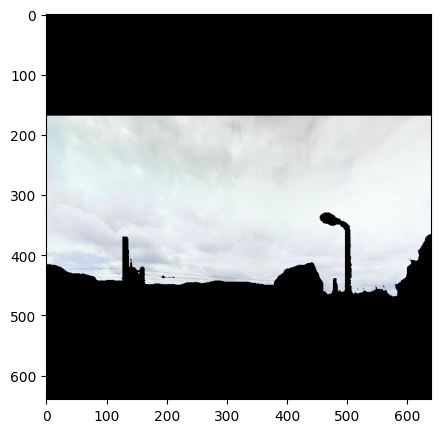

nail 89.63516998291016
hook 4.256387233734131
beacon 0.8309741616249084
pole 0.5825639367103577
screw 0.4575798809528351
megalith 0.42725586891174316
ostrich 0.34371861815452576
hay 0.31379616260528564
castle 0.3106779158115387
water tower 0.2998899221420288


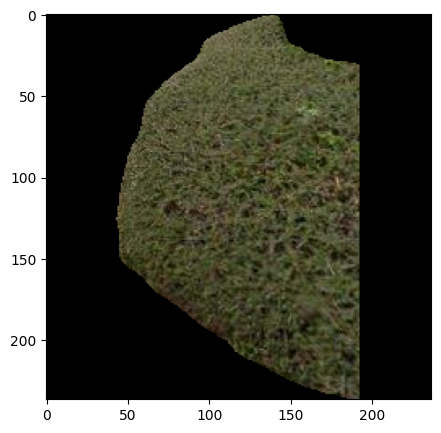

jackfruit 36.13618469238281
poncho 7.162078380584717
dishrag 3.8603532314300537
brain coral 3.694331169128418
electric ray 3.3143513202667236
bonnet 3.2042438983917236
stole 2.958094358444214
broccoli 2.816741704940796
diaper 2.4730682373046875
megalith 2.1662333011627197


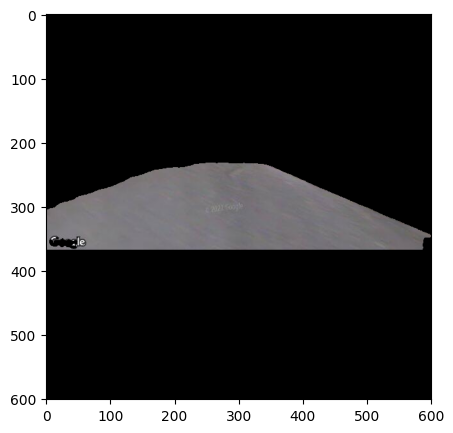

plastic bag 12.946693420410156
envelope 5.809261798858643
volcano 5.489529609680176
alp 3.293760061264038
mountain tent 2.88490891456604
gasmask 2.607982635498047
toilet tissue 2.161642074584961
abaya 1.6740785837173462
mask 1.6529788970947266
gown 1.567676067352295


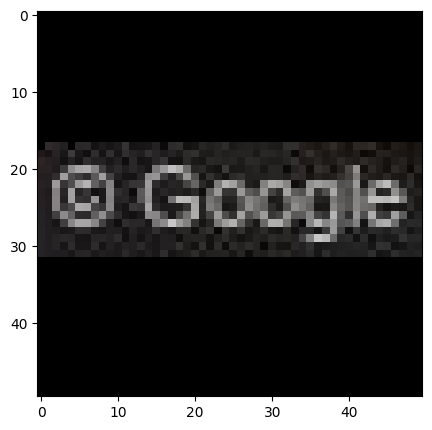

digital clock 5.257610321044922
panpipe 3.4273629188537598
abaya 3.3392977714538574
whistle 3.204287528991699
stopwatch 2.969919443130493
harmonica 2.495795726776123
chain 2.3910069465637207
lipstick 2.2616775035858154
digital watch 2.1243414878845215
oboe 2.0027542114257812


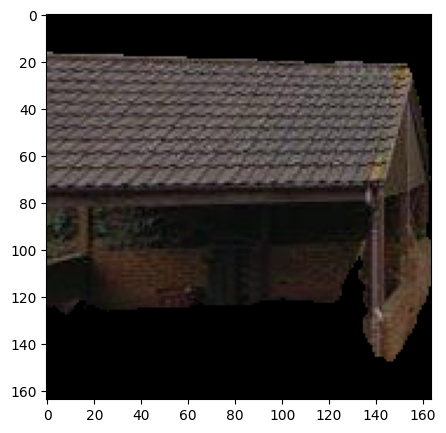

tile roof 82.14862060546875
boathouse 4.99636697769165
solar dish 4.157142162322998
bell cote 1.1781922578811646
lumbermill 0.46999141573905945
dome 0.41521912813186646
prison 0.3478734493255615
honeycomb 0.1833205372095108
doormat 0.17703811824321747
window screen 0.16987517476081848


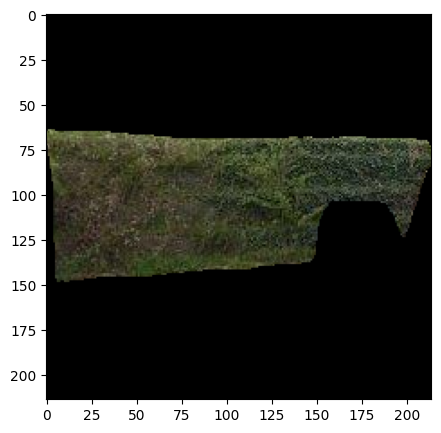

megalith 7.249773979187012
stone wall 2.720759868621826
American black bear 2.64943790435791
cliff 2.0624587535858154
nail 1.876771092414856
stupa 1.4693552255630493
castle 1.4492783546447754
hatchet 1.3954565525054932
screw 1.3711295127868652
leopard 1.2465100288391113


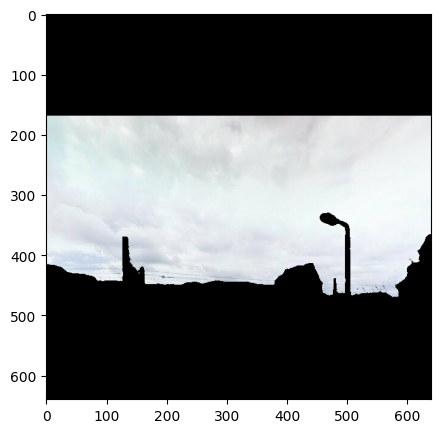

nail 55.862056732177734
hook 11.009378433227539
beacon 5.383913040161133
castle 4.098471641540527
pole 2.4111807346343994
flagpole 2.067354440689087
hay 1.7161656618118286
water tower 1.646406888961792
prison 1.6051604747772217
crane 1.5364549160003662


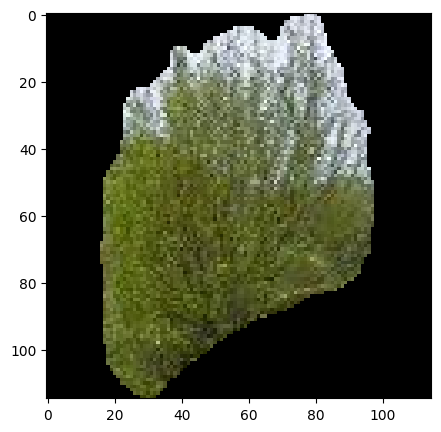

jackfruit 14.060537338256836
buckeye 10.594550132751465
chime 9.162332534790039
gong 6.0864105224609375
head cabbage 5.357839107513428
custard apple 3.3972580432891846
honeycomb 3.3969130516052246
Granny Smith 2.777808427810669
hen-of-the-woods 2.246243953704834
acorn 2.236074686050415


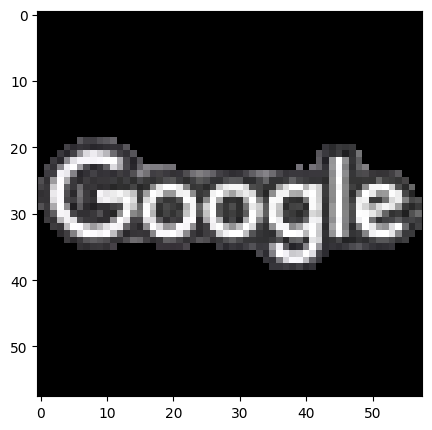

oboe 2.753883123397827
panpipe 2.364116668701172
whistle 2.0545198917388916
stopwatch 1.9845532178878784
chain 1.8621073961257935
digital clock 1.8570743799209595
theater curtain 1.85693359375
loupe 1.7321841716766357
pick 1.4871495962142944
bulletproof vest 1.4116119146347046


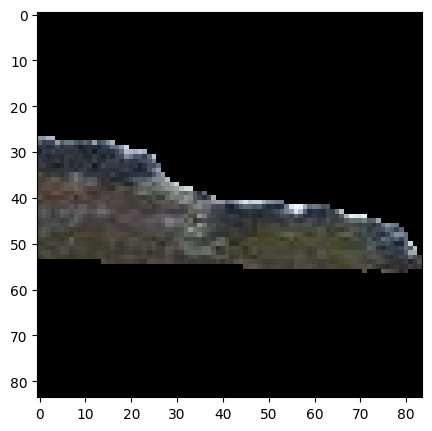

banded gecko 19.646512985229492
isopod 15.779350280761719
nematode 9.35188102722168
African chameleon 8.405550956726074
ibex 5.870804786682129
leatherback turtle 2.4326882362365723
common iguana 2.1782240867614746
common newt 1.792540192604065
sturgeon 1.6684364080429077
frilled lizard 1.5679033994674683


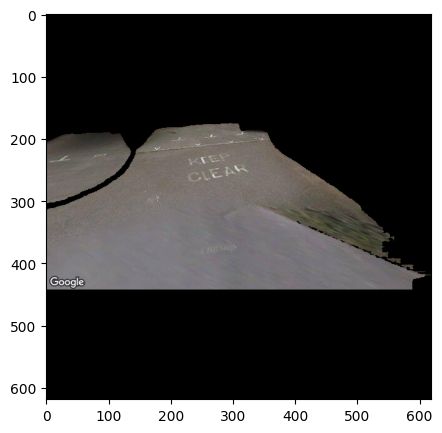

stingray 14.398890495300293
volcano 11.25961971282959
envelope 9.803068161010742
electric ray 7.88442325592041
gasmask 6.079087257385254
alp 2.0447957515716553
breastplate 1.7629425525665283
trilobite 1.5323790311813354
bulletproof vest 1.4821946620941162
oxygen mask 1.449481725692749


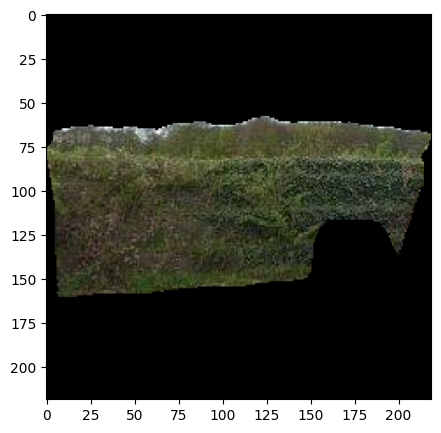

megalith 21.223020553588867
cliff 12.678858757019043
stone wall 6.553938865661621
promontory 5.705584526062012
ibex 5.118363857269287
alp 4.777199745178223
banded gecko 3.845914363861084
geyser 2.6833503246307373
African chameleon 2.478208303451538
oystercatcher 2.214031219482422


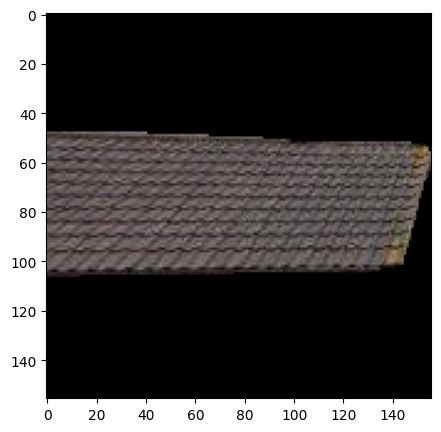

buckle 9.598352432250977
tile roof 9.097439765930176
Band Aid 3.736438274383545
doormat 3.3885278701782227
neck brace 2.610034465789795
stretcher 1.8211076259613037
chain 1.418768286705017
digital watch 1.3010444641113281
stopwatch 1.1098062992095947
ping-pong ball 1.0423853397369385


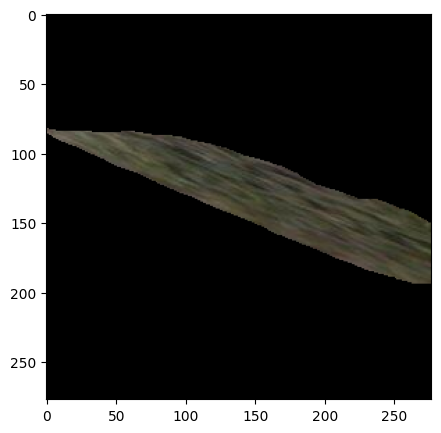

quill 92.82840728759766
nematode 1.0981711149215698
isopod 0.7782717943191528
letter opener 0.40178176760673523
ear 0.16895918548107147
American egret 0.12892182171344757
matchstick 0.12368381768465042
kite 0.11529208719730377
gar 0.1146828755736351
nail 0.10184674710035324


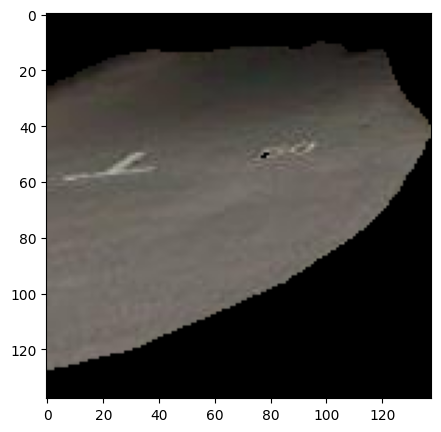

electric ray 21.162975311279297
chambered nautilus 3.883432626724243
mousetrap 3.5017035007476807
shovel 2.6656124591827393
tray 2.074188232421875
mask 1.629523754119873
quill 1.3554600477218628
stingray 1.2583389282226562
seashore 0.9780211448669434
leatherback turtle 0.9743568301200867


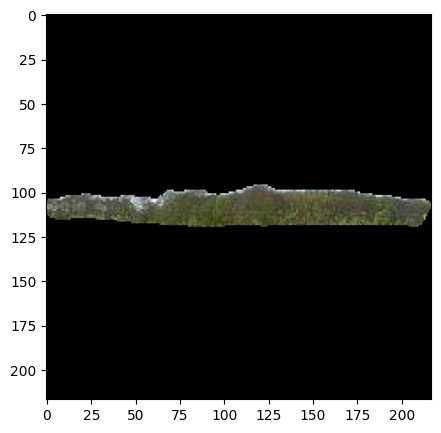

nematode 24.336578369140625
nail 7.389553546905518
vine snake 5.524782657623291
isopod 3.612929105758667
matchstick 3.2376976013183594
lacewing 2.4739787578582764
syringe 1.7171611785888672
tree frog 1.5452357530593872
banded gecko 1.416108250617981
lycaenid 1.368439793586731


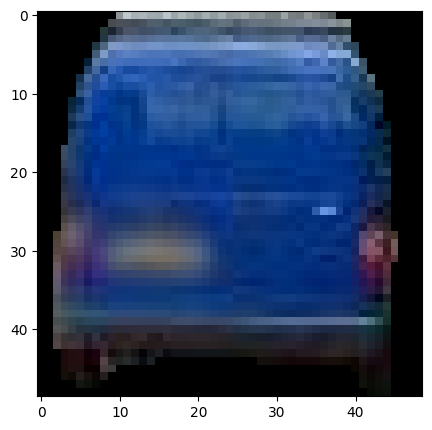

moving van 92.16971588134766
minibus 1.7697621583938599
trailer truck 1.7066316604614258
garbage truck 1.0331372022628784
oil filter 0.5871903300285339
passenger car 0.2523422837257385
hand-held computer 0.13641676306724548
harmonica 0.13336874544620514
thresher 0.12716855108737946
minivan 0.12622614204883575


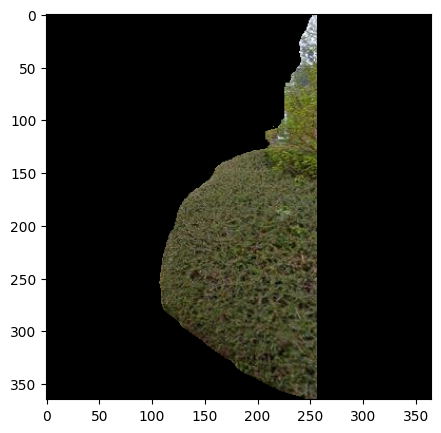

megalith 28.684810638427734
cliff 17.490564346313477
broccoli 8.594817161560059
stone wall 3.544039011001587
cliff dwelling 3.031208038330078
diaper 2.9236857891082764
valley 1.971842885017395
jackfruit 1.7884827852249146
pedestal 0.9802441000938416
castle 0.9103667736053467


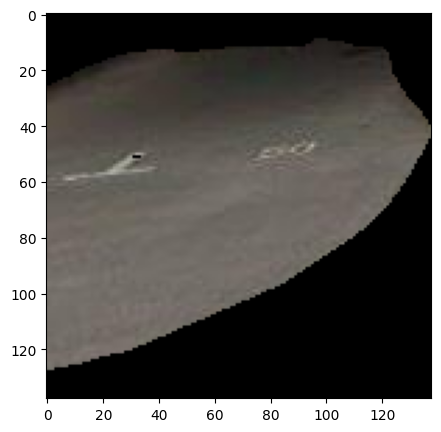

electric ray 41.060462951660156
stingray 4.3187384605407715
chambered nautilus 3.4171626567840576
tray 2.054555654525757
mousetrap 2.034839630126953
shovel 1.5799615383148193
mask 1.572600245475769
cleaver 1.430769920349121
aircraft carrier 1.4157005548477173
seashore 0.8659283518791199


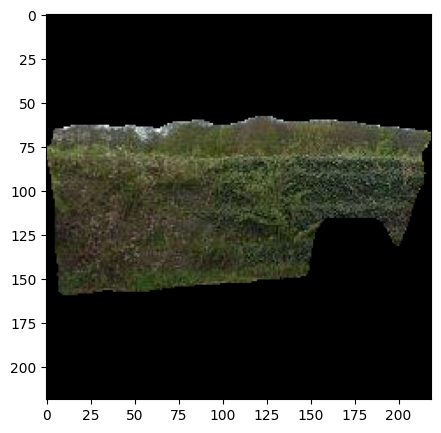

megalith 26.914756774902344
stone wall 10.694878578186035
cliff 10.675986289978027
African chameleon 3.293018341064453
banded gecko 3.11857008934021
promontory 2.45236873626709
nail 2.235832691192627
alp 2.1146366596221924
cliff dwelling 1.6795145273208618
oystercatcher 1.3762761354446411


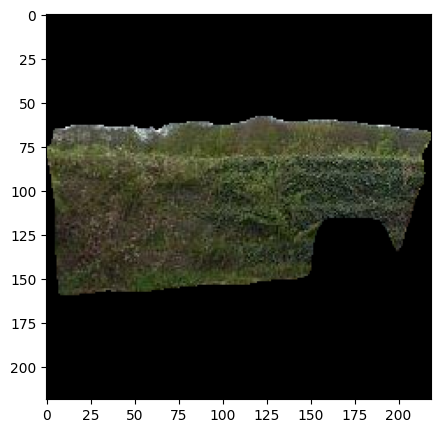

megalith 35.48800277709961
cliff 16.82932472229004
stone wall 7.840459823608398
promontory 5.488323211669922
alp 2.9910225868225098
ibex 2.9864649772644043
oystercatcher 2.058817148208618
cliff dwelling 1.7227286100387573
geyser 0.9535007476806641
beacon 0.9424585700035095


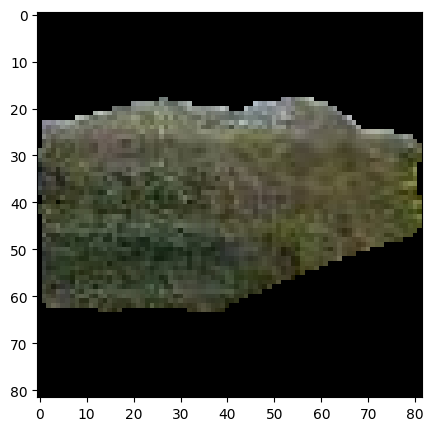

electric ray 10.47207260131836
banded gecko 8.910905838012695
alp 8.013787269592285
axolotl 7.791748523712158
African chameleon 6.332967281341553
sea cucumber 5.201230525970459
isopod 4.6128058433532715
promontory 4.244681358337402
chiton 2.8995115756988525
valley 2.0400962829589844


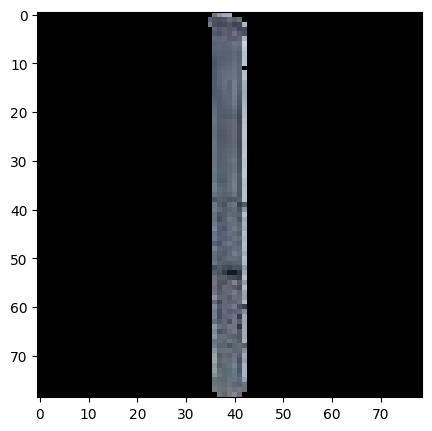

banjo 18.586366653442383
rule 13.730571746826172
electric guitar 8.555642127990723
spatula 6.385318279266357
acoustic guitar 3.7925515174865723
ladle 3.280184745788574
microphone 1.9248653650283813
pole 1.6394575834274292
syringe 1.5384807586669922
scale 1.4577451944351196


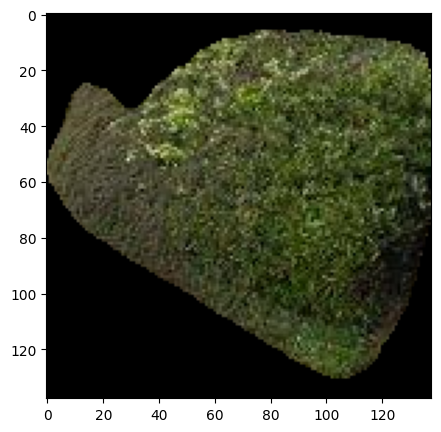

broccoli 92.0314712524414
electric ray 1.1800328493118286
shovel 0.8346238136291504
African chameleon 0.6842101216316223
head cabbage 0.2032891809940338
maze 0.1957380473613739
poncho 0.18030764162540436
chiton 0.17249204218387604
spatula 0.1719146966934204
valley 0.1333446055650711


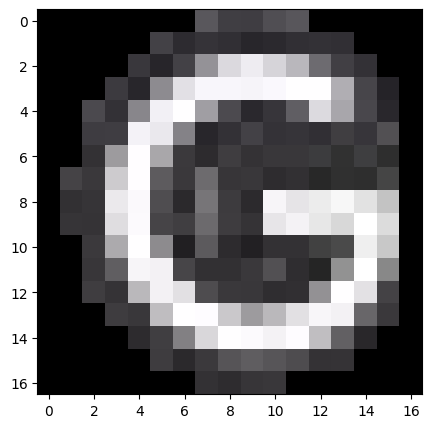

combination lock 21.72899627685547
typewriter keyboard 10.498991966247559
pick 7.078619480133057
oil filter 4.946538925170898
space bar 4.567679405212402
cassette player 4.033016204833984
chain mail 3.6218860149383545
safety pin 3.0336496829986572
analog clock 3.0267879962921143
stopwatch 2.9790492057800293


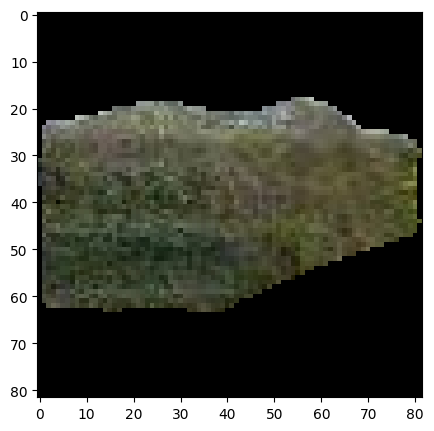

axolotl 9.846707344055176
electric ray 9.324355125427246
banded gecko 7.9709014892578125
alp 7.930911540985107
promontory 6.79162073135376
African chameleon 4.179597854614258
isopod 3.0564637184143066
ibex 2.62994384765625
valley 2.4076836109161377
sea cucumber 2.380082607269287


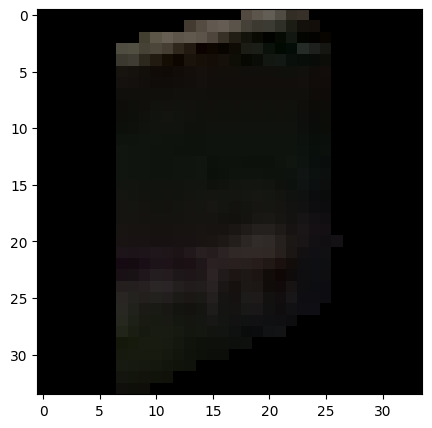

milk can 4.379612922668457
whiskey jug 3.8070335388183594
Windsor tie 2.1518983840942383
isopod 2.133920669555664
vine snake 2.026052236557007
fox squirrel 1.8903100490570068
platypus 1.5421119928359985
guillotine 1.379865288734436
table lamp 1.3163257837295532
abaya 1.3143656253814697


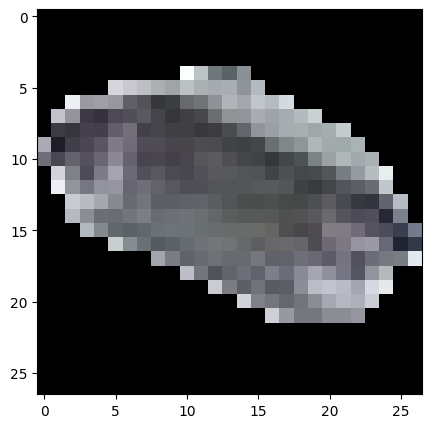

chain saw 57.935203552246094
can opener 15.619361877441406
loupe 4.181522369384766
isopod 3.040353298187256
triceratops 2.7744789123535156
cleaver 2.304814100265503
frilled lizard 1.4031414985656738
quill 1.279151201248169
chambered nautilus 1.2513716220855713
letter opener 1.174152135848999


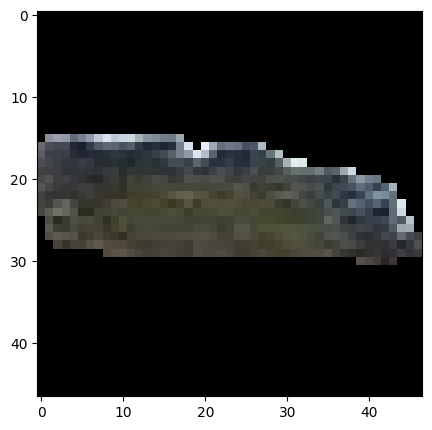

isopod 21.9917049407959
cleaver 9.000940322875977
banded gecko 4.322818756103516
nematode 4.241209506988525
chain saw 4.066589832305908
African chameleon 4.029350280761719
space shuttle 1.7767860889434814
black grouse 1.3000980615615845
triceratops 1.2957712411880493
platypus 1.2619099617004395


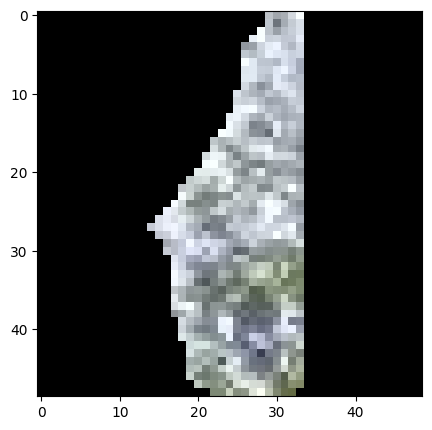

pedestal 15.983903884887695
abaya 14.682412147521973
bulletproof vest 9.745855331420898
Windsor tie 4.314398765563965
honeycomb 2.403839349746704
stole 2.304535150527954
vase 2.122526168823242
vestment 1.952077865600586
panpipe 1.8211033344268799
sarong 1.6613656282424927


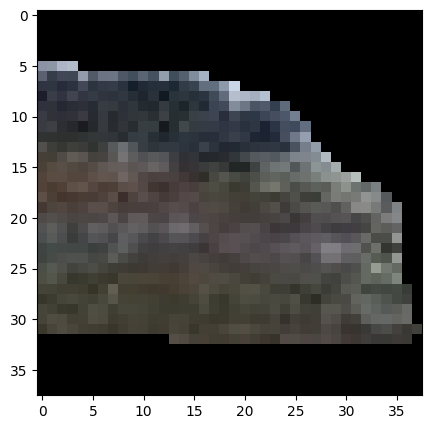

isopod 69.81363677978516
African chameleon 6.519145488739014
frilled lizard 3.57086181640625
chiton 3.0821969509124756
rock beauty 2.481215238571167
triceratops 2.3073647022247314
electric ray 1.5179606676101685
dugong 1.5054038763046265
banded gecko 0.9930242896080017
grey whale 0.7963013052940369


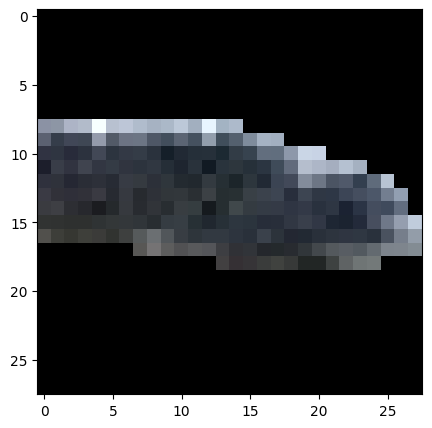

isopod 31.874046325683594
nematode 11.799827575683594
chain saw 8.708608627319336
space shuttle 5.402042865753174
triceratops 3.94897723197937
letter opener 3.374786376953125
cleaver 3.0902163982391357
banded gecko 1.826854944229126
hair slide 1.3063621520996094
panpipe 0.9428327083587646


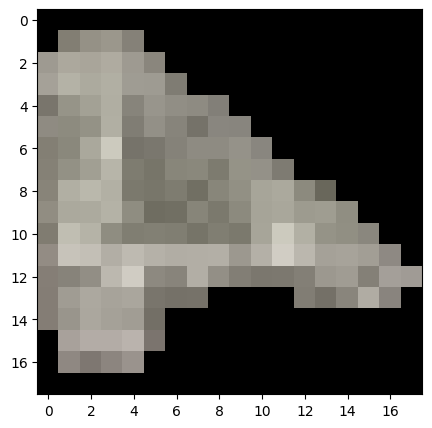

Sealyham terrier 48.69306182861328
Bedlington terrier 12.339227676391602
triceratops 10.258232116699219
Dandie Dinmont 7.041697978973389
isopod 1.8838083744049072
wire-haired fox terrier 1.7202790975570679
komondor 1.293176293373108
panpipe 0.9382914900779724
cleaver 0.8131018877029419
Windsor tie 0.7505240440368652


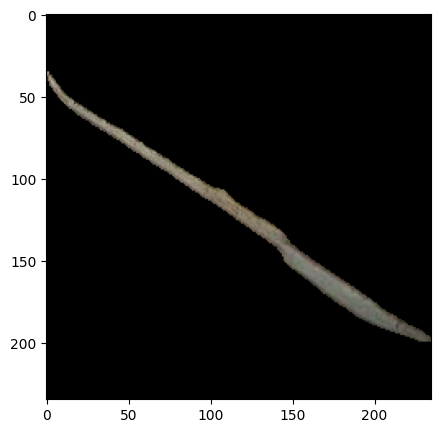

nematode 15.241143226623535
knot 9.078661918640137
matchstick 5.514880180358887
tennis ball 2.645841360092163
whistle 2.412818193435669
quill 2.015641212463379
safety pin 1.9871629476547241
syringe 1.7592599391937256
hook 1.5762265920639038
hatchet 1.4387136697769165


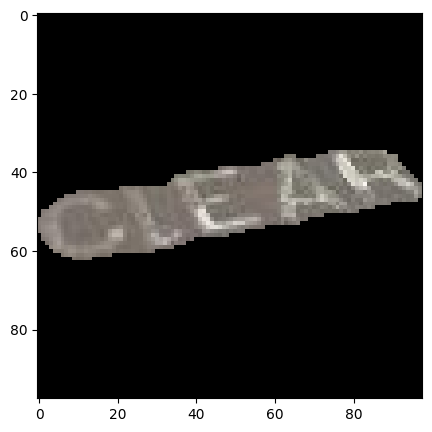

quill 33.30534362792969
letter opener 14.467700004577637
nematode 13.296346664428711
hair slide 10.591403007507324
isopod 3.673248767852783
banded gecko 1.629320502281189
ladle 1.548394799232483
cleaver 0.9170060157775879
can opener 0.6167041659355164
whistle 0.5837011337280273


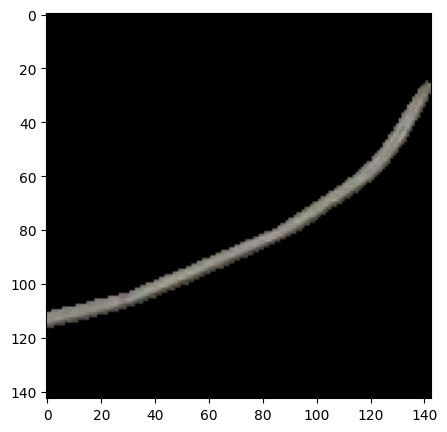

nematode 6.965318202972412
pay-phone 6.905734539031982
chain 6.905669212341309
pick 6.211028099060059
bolo tie 5.752951145172119
whistle 5.467123031616211
knot 3.736001968383789
iPod 3.7236485481262207
dial telephone 3.6157190799713135
necklace 3.442976236343384


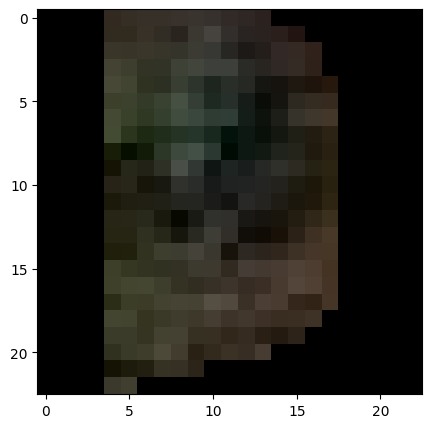

frilled lizard 5.326193332672119
isopod 5.283260345458984
Indian elephant 4.482869625091553
fox squirrel 3.9149839878082275
rock beauty 3.1792566776275635
Windsor tie 2.437314987182617
sloth bear 2.4095592498779297
tusker 2.085141897201538
gong 1.777466893196106
bearskin 1.6226390600204468


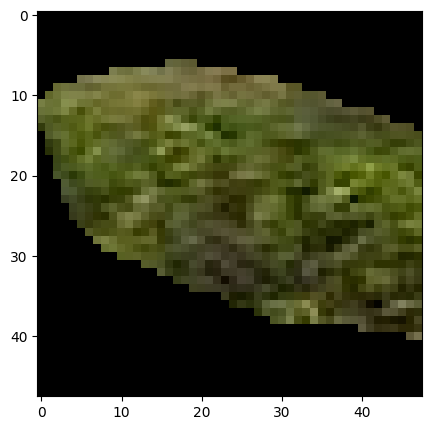

African chameleon 73.81961059570312
broccoli 11.015963554382324
custard apple 2.227726459503174
triceratops 1.8857922554016113
electric ray 1.7755852937698364
isopod 1.7398546934127808
rock beauty 0.9013438820838928
chiton 0.6575670838356018
brain coral 0.5971962213516235
banded gecko 0.3815198242664337


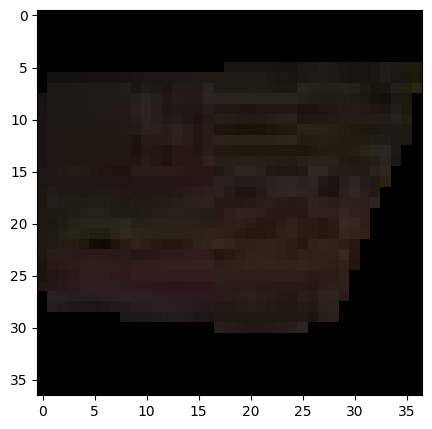

bulletproof vest 5.340737342834473
chambered nautilus 4.216092586517334
bolo tie 3.8269925117492676
whiskey jug 3.7106707096099854
Windsor tie 3.0700714588165283
cleaver 2.97055721282959
frilled lizard 2.8244831562042236
panpipe 2.630791664123535
hatchet 2.621778964996338
Indian cobra 2.022284984588623


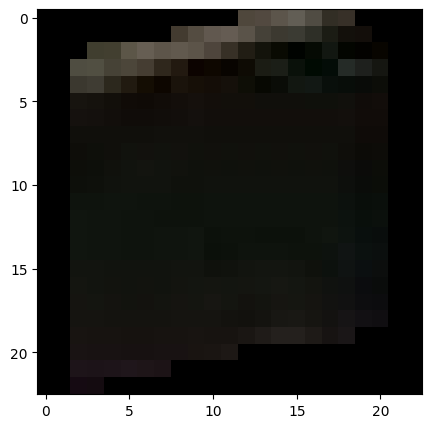

upright 4.764766693115234
binder 3.647603750228882
cassette player 2.881312370300293
whiskey jug 2.562788963317871
bulletproof vest 2.3459343910217285
Windsor tie 2.2898499965667725
cleaver 2.2431530952453613
abaya 2.1092379093170166
screen 1.7791943550109863
fire screen 1.6489661931991577


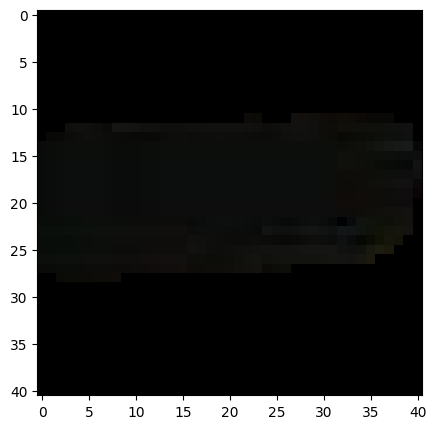

letter opener 2.220170021057129
nematode 2.1360182762145996
cleaver 1.9444648027420044
isopod 1.3476526737213135
banded gecko 1.3092708587646484
bulletproof vest 1.1383919715881348
chambered nautilus 1.137919306755066
spatula 1.0978442430496216
whiskey jug 1.092264175415039
upright 0.9405425786972046


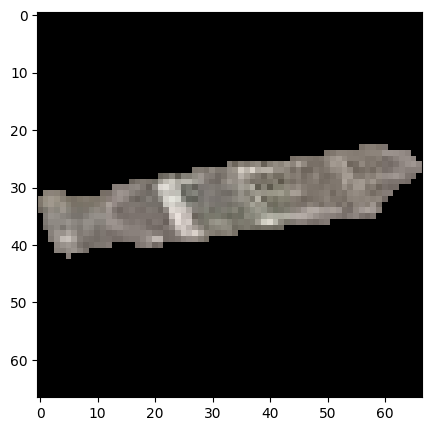

banded gecko 19.402618408203125
letter opener 17.643463134765625
nematode 13.5318021774292
isopod 6.542563438415527
quill 3.6148526668548584
cleaver 2.408515214920044
hair slide 2.305316925048828
chain saw 2.0140023231506348
scabbard 1.2537628412246704
hatchet 1.163694143295288


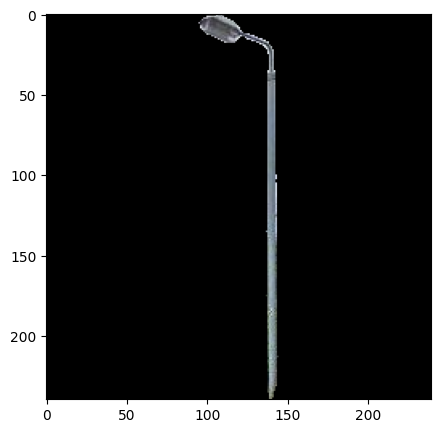

pole 78.27204132080078
flagpole 7.757146835327148
horizontal bar 3.0791890621185303
hook 2.37357234954834
spotlight 1.4862631559371948
microphone 0.4854494631290436
syringe 0.44943368434906006
lampshade 0.4415804147720337
crane 0.39413952827453613
street sign 0.37506136298179626


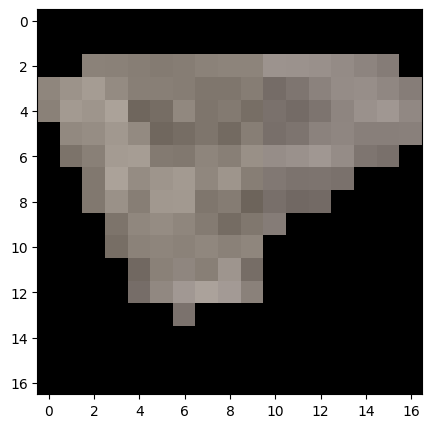

panpipe 82.9088363647461
hatchet 2.7832345962524414
isopod 1.8272621631622314
cleaver 0.9356621503829956
pedestal 0.6763275861740112
letter opener 0.5831904411315918
Sealyham terrier 0.5709652900695801
bolo tie 0.43413349986076355
revolver 0.35066893696784973
quill 0.3331913352012634


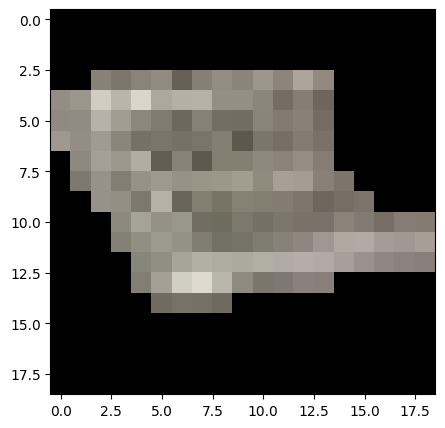

pedestal 12.91151237487793
panpipe 11.107853889465332
whiskey jug 10.348298072814941
plate rack 5.255391597747803
milk can 4.96891450881958
letter opener 4.2928571701049805
cleaver 2.5528042316436768
oil filter 2.2293426990509033
harmonica 2.098973512649536
whistle 1.9699536561965942


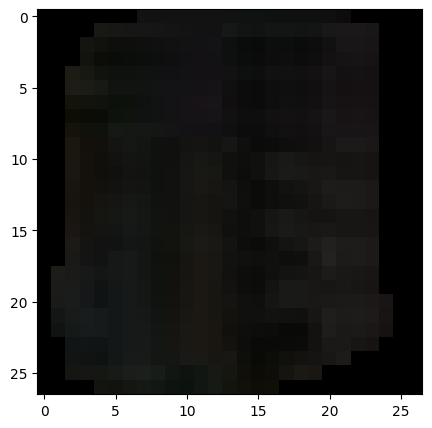

fire screen 5.062753200531006
abaya 4.14032506942749
bulletproof vest 2.9981021881103516
bearskin 2.7304670810699463
whiskey jug 2.3748910427093506
Windsor tie 2.0497260093688965
binder 2.044499635696411
upright 2.008291006088257
pedestal 1.9938675165176392
milk can 1.8874930143356323


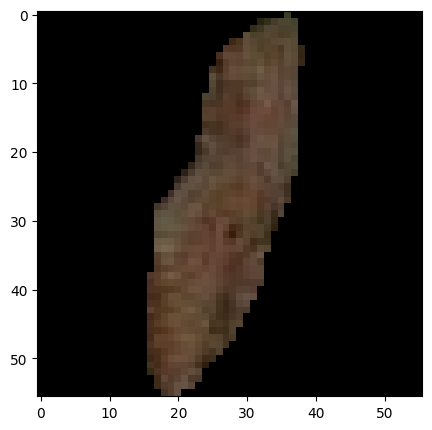

isopod 16.260643005371094
banded gecko 12.294632911682129
nematode 9.599119186401367
frilled lizard 5.615793704986572
quill 3.259930372238159
chiton 2.550438642501831
horned viper 2.4502205848693848
conch 2.2121708393096924
chambered nautilus 2.00797700881958
African chameleon 1.8903130292892456


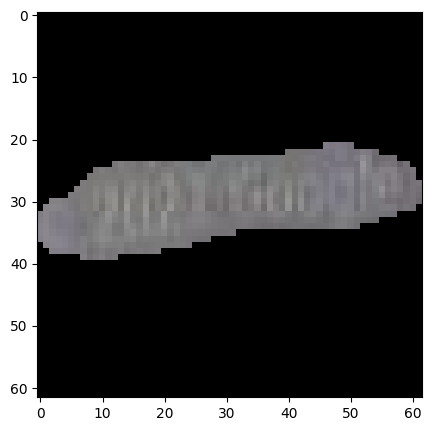

banded gecko 13.251583099365234
panpipe 8.898338317871094
letter opener 6.362768173217773
hatchet 4.7640180587768555
quill 4.041049480438232
plunger 3.6043238639831543
nematode 2.471623659133911
isopod 2.005380392074585
conch 1.9774056673049927
bulletproof vest 1.900490403175354


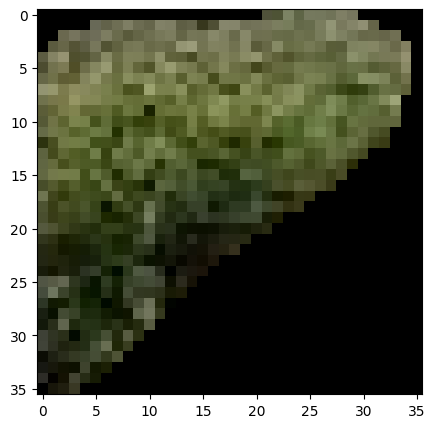

broccoli 33.657230377197266
cauliflower 2.782663345336914
African chameleon 2.558459997177124
fox squirrel 2.2841637134552
cardoon 2.1649839878082275
polecat 2.0110063552856445
custard apple 1.9397029876708984
head cabbage 1.9296014308929443
black stork 1.5869615077972412
vine snake 1.3076318502426147


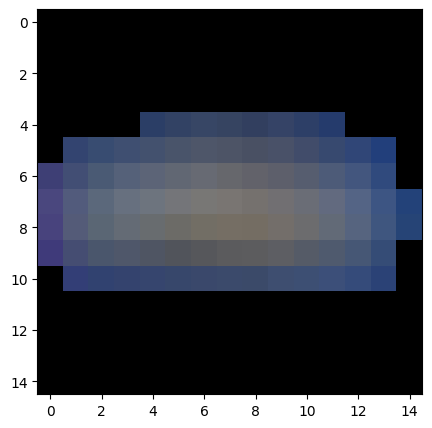

nipple 15.399873733520508
Band Aid 8.768451690673828
cleaver 6.039152145385742
lotion 5.7551350593566895
pill bottle 4.249586582183838
sunscreen 4.006192684173584
hair spray 3.6025843620300293
spatula 2.505972385406494
whistle 2.282376527786255
beaker 2.1310994625091553


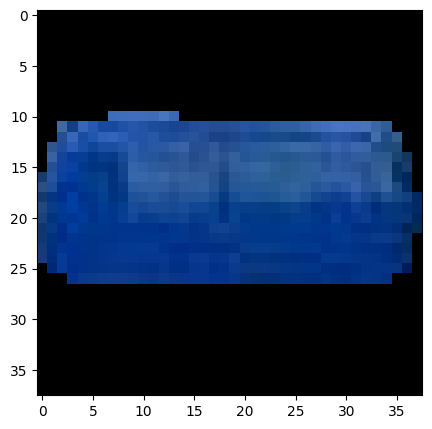

harmonica 15.568418502807617
whistle 13.539679527282715
Band Aid 7.695673942565918
letter opener 7.672528266906738
spatula 6.339474678039551
slide rule 3.4565534591674805
cleaver 2.921011209487915
studio couch 2.158799171447754
balance beam 1.5792515277862549
lipstick 1.4385833740234375


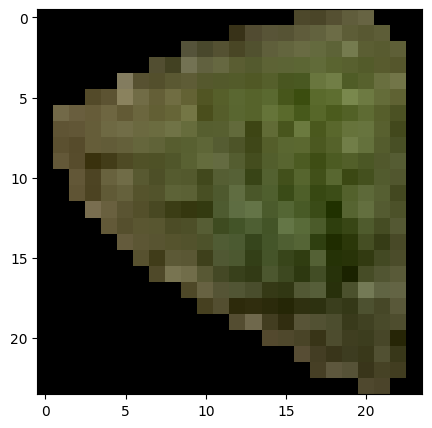

African chameleon 41.5895881652832
isopod 8.330888748168945
panpipe 8.092289924621582
frilled lizard 7.289186000823975
triceratops 4.191673755645752
chain saw 4.096852779388428
custard apple 3.036087989807129
banded gecko 2.612409830093384
black stork 2.324242353439331
cardoon 1.0928056240081787


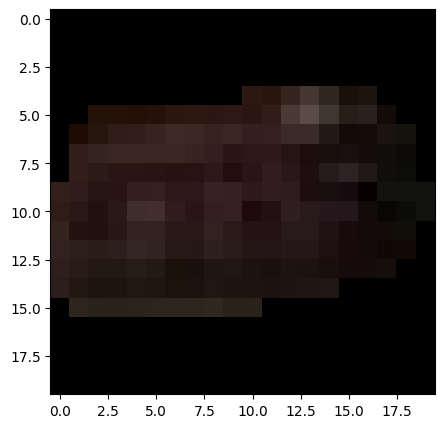

ocarina 5.774022579193115
whiskey jug 5.644935607910156
Windsor tie 4.936403274536133
harmonica 4.8256120681762695
moving van 3.6724660396575928
spatula 2.9956536293029785
letter opener 2.670520067214966
cassette player 2.4581382274627686
isopod 2.4530892372131348
tobacco shop 2.203510046005249


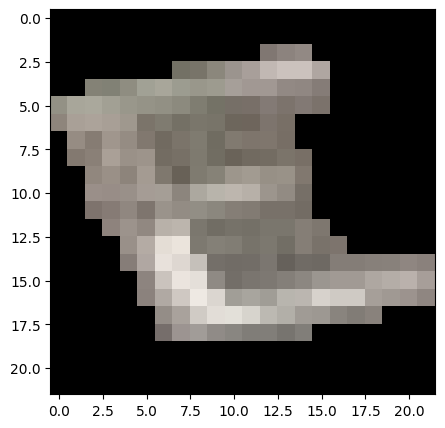

cleaver 12.193807601928711
revolver 10.353883743286133
spatula 7.470093727111816
panpipe 5.88579797744751
letter opener 4.37188720703125
hatchet 3.561288595199585
whistle 3.4302592277526855
loupe 3.0047128200531006
can opener 2.8797495365142822
pedestal 2.7939682006835938


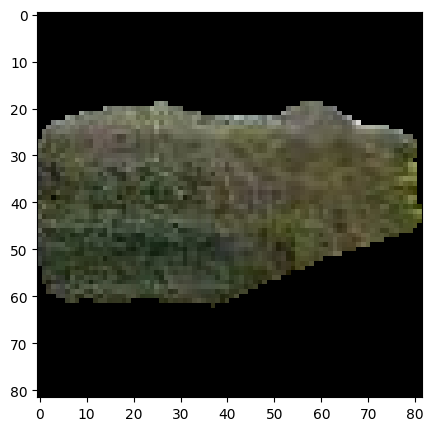

promontory 17.53012466430664
alp 9.727559089660645
volcano 7.276158809661865
banded gecko 3.4457225799560547
valley 3.3650457859039307
seashore 3.198711633682251
axolotl 2.887216329574585
geyser 2.7188913822174072
isopod 2.4332633018493652
electric ray 2.2573561668395996


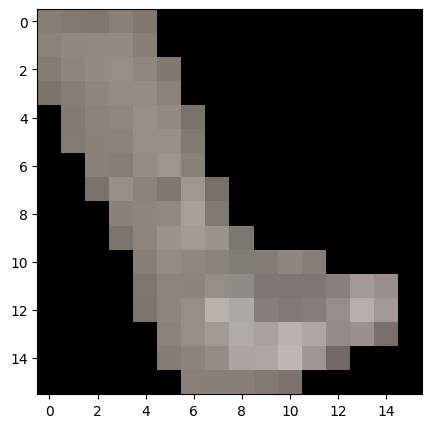

panpipe 93.76813507080078
upright 1.4997472763061523
isopod 0.7520314455032349
plunger 0.2563526928424835
screw 0.16266967356204987
bearskin 0.12244724482297897
harp 0.11618634313344955
hatchet 0.1122618243098259
banded gecko 0.10580964386463165
pick 0.09598596394062042


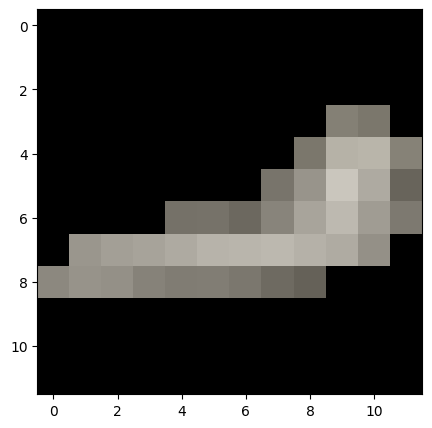

spatula 16.28261375427246
cleaver 12.178923606872559
letter opener 5.853500843048096
hatchet 3.9622769355773926
whistle 3.434967517852783
plunger 2.255420684814453
can opener 2.046346426010132
dishwasher 1.7906272411346436
Windsor tie 1.6821337938308716
chain saw 1.5108245611190796


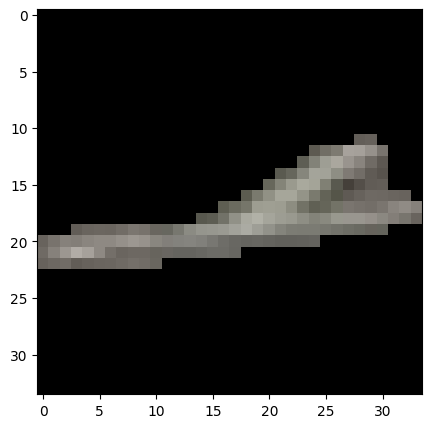

letter opener 4.555997371673584
plunger 3.525676965713501
cleaver 2.604572296142578
chain saw 2.226696729660034
oboe 2.161548137664795
upright 2.144874095916748
hatchet 2.104055404663086
panpipe 2.0312750339508057
bolo tie 1.8530217409133911
loupe 1.8114047050476074


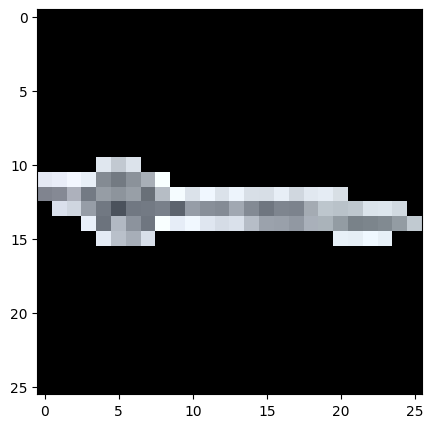

letter opener 76.45906066894531
syringe 5.952307224273682
spatula 3.258265256881714
loupe 2.9096171855926514
whistle 1.4491015672683716
cleaver 0.6332747936248779
ladle 0.48969486355781555
screwdriver 0.4589306712150574
assault rifle 0.437050461769104
can opener 0.42510321736335754


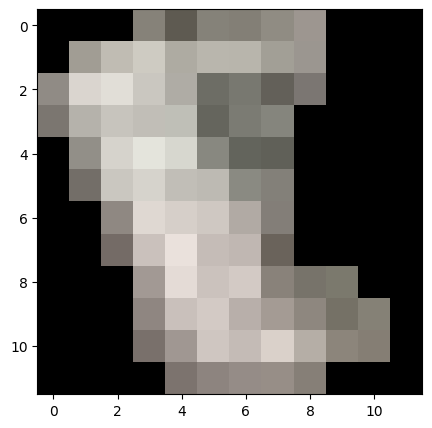

Dandie Dinmont 13.55553150177002
Sealyham terrier 13.153290748596191
Japanese spaniel 12.262495040893555
wire-haired fox terrier 6.476437091827393
affenpinscher 5.090399265289307
Bedlington terrier 3.7864513397216797
Windsor tie 3.4548163414001465
Persian cat 2.6480839252471924
Old English sheepdog 1.883606195449829
milk can 1.5740129947662354


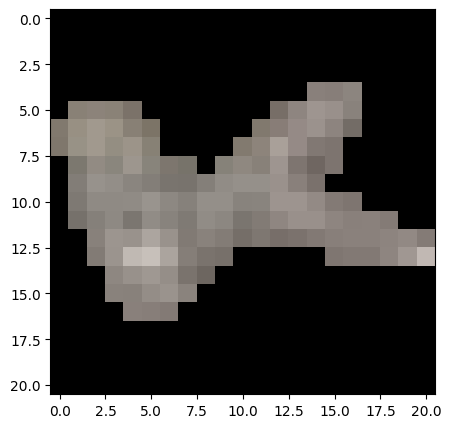

panpipe 23.94706153869629
letter opener 10.102648735046387
Sealyham terrier 5.661200046539307
triceratops 4.185283184051514
bolo tie 3.286271095275879
hatchet 3.1267471313476562
Windsor tie 2.8215510845184326
banded gecko 2.721256971359253
pick 2.1113717555999756
loupe 1.8065412044525146


In [ ]:
masked_image = getResnetMasks(test_image, test_image_masks)

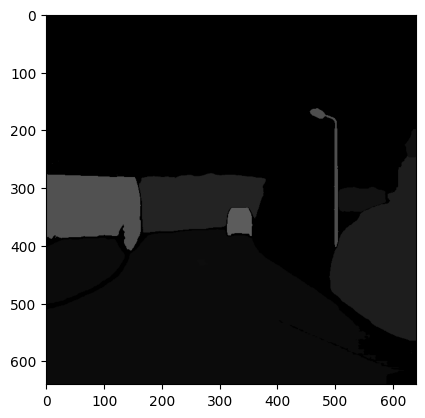

In [ ]:
plt.imshow(masked_image, cmap="gray", vmin=0, vmax=255)
plt.show()

#### Applying to all Images
takes long time to run ~7days

In [ ]:
import os
directory_path = "./Images/weighted_masks/"
skip = True
for root, dirs, files in os.walk(directory_path):

    current_dir = os.path.basename(root)

    if current_dir == "Argentina":
        skip = False

    if skip:
        continue

    for file in files:

        folder_path = f"./Images/weighted_masks/{current_dir}"
        if not os.path.exists(os.path.join(folder_path, file)):
            image_ = cv2.cvtColor(cv2.imread(os.path.join(root,file)), cv2.COLOR_BGR2RGB)
            image_masks = mask_generator.generate(image_)
            new_image = Image.fromarray(getResnetMasks(image_, image_masks).astype(np.uint8))


            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            new_image.save(os.path.join(folder_path, file))


## Import and Apply Formatting to Im2GPS3k
same workflow as before, get countries from coordinats and apply folder format

In [ ]:
#Get IM2GPS3k images from http://www.mediafire.com/file/7ht7sn78q27o9we/im2gps3ktest.zip <- can't wget because of mediafire

In [ ]:
# import wget
# url = "https://raw.githubusercontent.com/TIBHannover/GeoEstimation/original_tf/meta/im2gps3k_places365.csv"
# wget.download(url)
#csv of locations of images in the dataset

In [ ]:
im2gps3k_locations = pd.read_csv("im2gps3k_places365.csv")

In [ ]:
im2gps3k_locations.head()

,IMG_ID,AUTHOR,LAT,LON,S3_Label,S16_Label,S365_Label,Prob_indoor,Prob_natural,Prob_urban
0,1000269685_e60e9cdfb4_1125_78841376@N00.jpg,78841376@N00,32.325436,-64.764404,2,12,353,0.274242,0.045113,0.680645
1,1000304467_1a75a200b1_1296_78841376@N00.jpg,78841376@N00,32.325436,-64.764404,0,4,325,0.414407,0.220912,0.364681
2,1001048550_8e4b47d165_1051_78841376@N00.jpg,78841376@N00,32.325436,-64.764404,1,8,36,0.007326,0.969903,0.022771
3,1005977048_5ccf8b05d3_1201_91728102@N00.jpg,91728102@N00,29.976052,122.390356,2,6,273,0.003868,0.476665,0.519468
4,1008804117_ce4e6fef8a_1349_97522422@N00.jpg,97522422@N00,46.478536,30.758714,0,0,198,0.973878,0.002453,0.023670


In [ ]:
im2gps3k_locations = im2gps3k_locations.loc[:, ["IMG_ID", "LAT", "LON"]]

In [ ]:
im2gps3k_locations.head()

,IMG_ID,LAT,LON
0,1000269685_e60e9cdfb4_1125_78841376@N00.jpg,32.325436,-64.764404
1,1000304467_1a75a200b1_1296_78841376@N00.jpg,32.325436,-64.764404
2,1001048550_8e4b47d165_1051_78841376@N00.jpg,32.325436,-64.764404
3,1005977048_5ccf8b05d3_1201_91728102@N00.jpg,29.976052,122.390356
4,1008804117_ce4e6fef8a_1349_97522422@N00.jpg,46.478536,30.758714


In [ ]:
im2gps3ktuples = list(zip(im2gps3k_locations['LAT'], im2gps3k_locations['LON']))

In [ ]:
im2gps3kresults = rg.search(im2gps3ktuples)

Loading formatted geocoded file...


In [ ]:
im2gps3kresults = rg.search(im2gps3ktuples)

In [ ]:
i_cc_list = [e['cc'] for e in im2gps3kresults ]
i_country_cc_df = pd.DataFrame({'cc': i_cc_list})
i_country_cc_df = i_country_cc_df.merge(country_df, how="left", left_on='cc', right_on='ISO')

In [ ]:
i_country_cc_df

,cc,ISO,Name
0,BM,BM,Bermuda
1,BM,BM,Bermuda
2,BM,BM,Bermuda
3,CN,CN,China
4,UA,UA,Ukraine
...,...,...,...
2992,US,US,United States
2993,AW,AW,Aruba
2994,AW,AW,Aruba
2995,GB,GB,United Kingdom


In [ ]:
im2gps3k_locations['country'] = i_country_cc_df['Name']

In [ ]:
im2gps3k_locations.head()

,IMG_ID,LAT,LON,country
0,1000269685_e60e9cdfb4_1125_78841376@N00.jpg,32.325436,-64.764404,Bermuda
1,1000304467_1a75a200b1_1296_78841376@N00.jpg,32.325436,-64.764404,Bermuda
2,1001048550_8e4b47d165_1051_78841376@N00.jpg,32.325436,-64.764404,Bermuda
3,1005977048_5ccf8b05d3_1201_91728102@N00.jpg,29.976052,122.390356,China
4,1008804117_ce4e6fef8a_1349_97522422@N00.jpg,46.478536,30.758714,Ukraine


In [ ]:
a = pd.read_csv("final_df.csv")

In [ ]:
countries_over_75 = a['country'].value_counts()[a['country'].value_counts() >= 75].index

In [ ]:
countries_over_75

Index(['United States', 'Japan', 'France', 'Brazil', 'Australia',
       'United Kingdom', 'Russia', 'Argentina', 'Poland', 'Canada', 'Mexico',
       'South Africa', 'Finland', 'Spain', 'Thailand', 'Italy', 'Sweden',
       'Turkey', 'Nigeria', 'Germany', 'Portugal', 'Malaysia', 'Netherlands',
       'Singapore', 'Norway', 'South Korea', 'Austria', 'India', 'Indonesia',
       'Colombia', 'Ireland', 'Romania', 'New Zealand', 'Taiwan', 'Czechia',
       'Israel', 'Chile', 'Peru', 'Belgium', 'Switzerland', 'Bulgaria',
       'Kenya', 'Philippines', 'Sri Lanka', 'Botswana', 'Denmark', 'Mongolia',
       'Lithuania', 'Greece', 'Ukraine', 'Slovakia', 'Bolivia', 'Hungary',
       'Bangladesh', 'Croatia', 'Senegal', 'Ghana', 'Cambodia', 'Uruguay',
       'Latvia', 'Ecuador', 'Palestine', 'Estonia', 'Serbia', 'Tunisia',
       'Guatemala', 'Hong Kong', 'Kyrgyzstan', 'Jordan', 'Slovenia', 'Iceland',
       'Lesotho', 'Eswatini'],
      dtype='object', name='country')

In [ ]:
im2gps3k_filtered = im2gps3k_locations[im2gps3k_locations['country'].isin(countries_over_75)]


In [ ]:
im2gps3k_filtered

,IMG_ID,LAT,LON,country
4,1008804117_ce4e6fef8a_1349_97522422@N00.jpg,46.478536,30.758714,Ukraine
5,1008845063_ace4ef829f_1204_97522422@N00.jpg,46.478536,30.758714,Ukraine
6,101220879_0a1be45b79_33_24311489@N00.jpg,42.249915,-87.827110,United States
7,1014898753_ef4cfaa5d6_1354_96928198@N00.jpg,62.140088,6.074967,Norway
9,1021054395_ca7cfe55b3_1061_7132415@N03.jpg,-0.400997,-90.704498,Ecuador
...,...,...,...,...
2990,98906596_9253c76237_43_41894169878@N01.jpg,40.800263,-73.949146,United States
2991,99060686_1703e6da35_41_44972214@N00.jpg,32.759562,-117.180175,United States
2992,99078324_9d8e7a3975_28_44972214@N00.jpg,32.759562,-117.180175,United States
2995,995674057_2360a67996_1182_98545448@N00.jpg,51.682462,-1.786330,United Kingdom


In [ ]:
import os #move images that fall into our 73 countries
import shutil
for index, row in im2gps3k_filtered.iterrows():
    source_path = os.path.join("im2gps3ktest/", row['IMG_ID'])
    destination_path = os.path.join("im2gps3k/", row['country'], row['IMG_ID'])
    if not os.path.exists(os.path.dirname(destination_path)):
        os.makedirs(os.path.dirname(destination_path))
    shutil.move(source_path, destination_path)

In [ ]:
countries_over_75

Index(['United States', 'Japan', 'France', 'Brazil', 'Australia',
       'United Kingdom', 'Russia', 'Argentina', 'Poland', 'Canada', 'Mexico',
       'South Africa', 'Finland', 'Spain', 'Thailand', 'Italy', 'Sweden',
       'Turkey', 'Nigeria', 'Germany', 'Portugal', 'Malaysia', 'Netherlands',
       'Singapore', 'Norway', 'South Korea', 'Austria', 'India', 'Indonesia',
       'Colombia', 'Ireland', 'Romania', 'New Zealand', 'Taiwan', 'Czechia',
       'Israel', 'Chile', 'Peru', 'Belgium', 'Switzerland', 'Bulgaria',
       'Kenya', 'Philippines', 'Sri Lanka', 'Botswana', 'Denmark', 'Mongolia',
       'Lithuania', 'Greece', 'Ukraine', 'Slovakia', 'Bolivia', 'Hungary',
       'Bangladesh', 'Croatia', 'Senegal', 'Ghana', 'Cambodia', 'Uruguay',
       'Latvia', 'Ecuador', 'Palestine', 'Estonia', 'Serbia', 'Tunisia',
       'Guatemala', 'Hong Kong', 'Kyrgyzstan', 'Jordan', 'Slovenia', 'Iceland',
       'Lesotho', 'Eswatini'],
      dtype='object', name='country')

In [ ]:
for i in countries_over_75: #create empty folders that dont exist to match our 73 classes
    if not os.path.exists(os.path.dirname(os.path.join("im2gps3k", i, "1"))):
         os.makedirs(os.path.dirname(os.path.join("im2gps3k", i, "1")))